In [32]:
import matplotlib.pyplot as plt
import json
import pandas as pd
from scipy.stats import wilcoxon, mannwhitneyu, false_discovery_control

In [22]:
bird_quiz_scores = { 
    "05": 64.41, "06": 49.15, "07": 61.02, "08": 88.14, "09": 67.80, "10": 57.63, "11": 67.80, 
    "12": 71.19, "14": 62.71, "15": 44.07, "16": 67.80, "17": 62.71, "18": 61.02, 
    "19": 54.24, "20": 47.46, "21": 47.46, "22": 50.85, "23": 47.46, "24": 69.49, "25": 57.63, 
    "26": 72.88, "27": 64.41, "28": 40.68, "29": 37.29, "30": 64.41, "31": 64.41, "32": 37.29, 
    "33": 52.54, "34": 54.24
}

one_back_scores = {
     "05": 34, "06": 26, "07": 33, "08": 43, "09": 34, "10": 31, "11": 35, "12": 37, "14": 32, 
     "15": 25, "16": 35, "17": 33, "18": 32, "19": 29, "20": 26, "21": 28, "22": 24, "23": 27, 
     "24": 36, "25": 31, "26": 37, "27": 32, "28": 22, "29": 21, "30": 34, "31": 35, "32": 19, 
     "33": 30, "34": 29
}

expertise_groups = {
    "Low": range(19, 30),
    "Moderate": range(30, 34),
    "Advanced": range(34, 44)
}

In [23]:
accuracy_file = open("ROI_accuracies_1.json")
accuracy_scores = json.load(accuracy_file)
acc_scores_df = pd.DataFrame(accuracy_scores).T

acc_scores_df.rename(columns={'140': 'TPOJ2', '11': 'PEF', '85': 'a9-46v', '83': 'p9-46v', '82': 'IFSa', '87': '9a'}, inplace=True)

In [24]:
acc_scores_df.drop(["13"], axis=0, inplace=True) # participant 13 not included in analysis
acc_scores_df["one_back_scores"] = one_back_scores.values()

acc_scores_df.head(3)

,FFC,V1,V2,V3,V3A,V3B,V3CD,V4,V6,V7,...,LO2,PIT,VVC,TPOJ2,PEF,a9-46v,p9-46v,IFSa,9a,one_back_scores
05,53.018,57.062,56.673,60.788,50.203,51.575,52.362,54.858,49.820,52.982,...,52.685,57.130,55.388,52.605,51.432,55.752,52.543,50.945,49.110,34
06,52.107,51.945,56.733,50.385,52.752,53.277,52.135,50.412,53.123,48.278,...,48.358,54.413,52.842,46.828,52.482,51.143,53.087,49.222,51.813,26
07,50.328,61.137,57.278,57.315,50.660,55.808,56.935,58.393,55.212,55.037,...,55.747,54.717,54.260,49.883,47.555,50.587,50.847,55.223,51.698,33


In [25]:
score_groups = [18, 29, 33, 44]
labels = ['Low', 'Moderate', 'Advanced'] 

acc_scores_df['score_range'] = pd.cut(acc_scores_df['one_back_scores'], bins=score_groups, labels=labels)

C:\Users\James\AppData\Local\Temp\ipykernel_28148\1880124821.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_avg = acc_scores_df.groupby('score_range').mean()


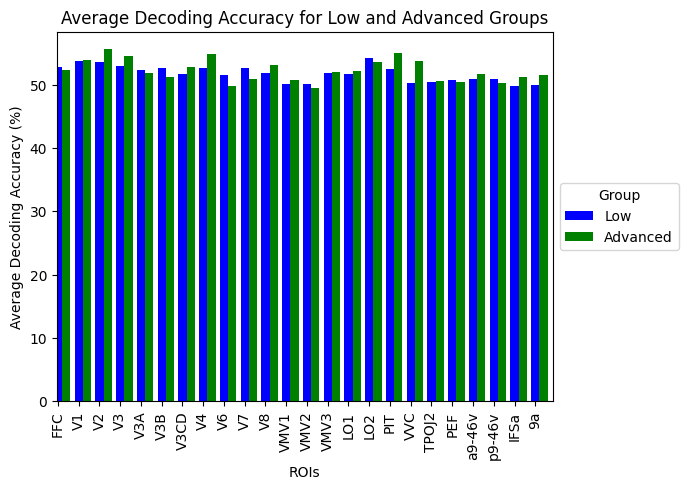

In [26]:
grouped_avg = acc_scores_df.groupby('score_range').mean()
grouped_avg.drop("one_back_scores", axis=1, inplace=True)

grouped_avg_subset = grouped_avg.loc[['Low', 'Advanced']]

fig, ax = plt.subplots()

grouped_avg_subset.loc['Low'].plot(kind='bar', color='blue', position=0.5, width=0.4, ax=ax)

grouped_avg_subset.loc['Advanced'].plot(kind='bar', color='green', position=-0.5, width=0.4, ax=ax)

plt.xlabel('ROIs')  
plt.ylabel('Average Decoding Accuracy (%)')
plt.title('Average Decoding Accuracy for Low and Advanced Groups') 
plt.legend(title='Group', loc='center left', bbox_to_anchor=(1, 0.5))  
plt.show()

C:\Users\James\AppData\Local\Temp\ipykernel_28148\2968711292.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_mean = acc_scores_df.groupby('score_range').mean()


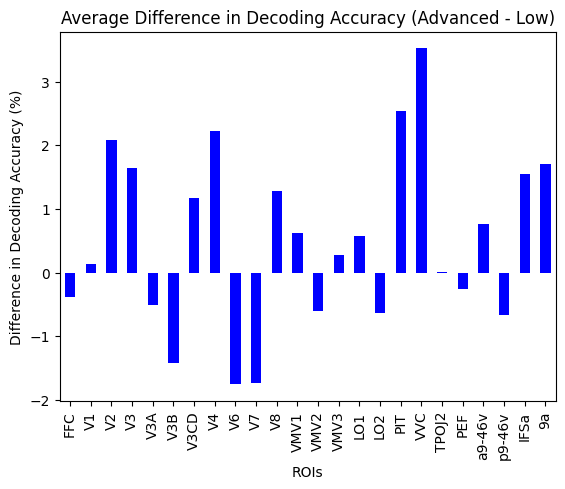

In [43]:
grouped_mean = acc_scores_df.groupby('score_range').mean()
grouped_mean.drop("one_back_scores", axis=1, inplace=True)

difference = grouped_mean.loc['Advanced'] - grouped_mean.loc['Low']

difference.plot(kind='bar', color='blue')

plt.xlabel('ROIs')
plt.ylabel('Difference in Decoding Accuracy (%)')  
plt.title('Average Difference in Decoding Accuracy (Advanced - Low)')
plt.show()

In [37]:
print(f"Number of low expertise participants: {acc_scores_df.groupby('score_range', observed=True).size()['Low']}")
print(f"Number of advanced expertise participants: {acc_scores_df.groupby('score_range', observed=True).size()['Advanced']}\n")
grouped_expertise_levels = acc_scores_df.groupby('score_range', observed=False)
p_values = []
p_val_dict = {}

for col in acc_scores_df.columns:
    if col not in ['score_range', 'one_back_scores']:
        low_score_df = grouped_expertise_levels.get_group('Low')
        moderate_score_df = grouped_expertise_levels.get_group('Moderate')
        advanced_score_df = grouped_expertise_levels.get_group('Advanced')


        U1, p = mannwhitneyu(advanced_score_df[col], low_score_df[col], method="exact")
        p_values.append(p)

        if p < 0.05:
            print(f"P-value for {col}: {p}")

false_disc = false_discovery_control(p_values)
print(false_disc)

for i, col in enumerate(acc_scores_df.columns):
    if col not in ['score_range', 'one_back_scores']:
        p_val_dict[col] = false_disc[i]

print(json.dumps(p_val_dict, sort_keys=True, indent=4))

Number of low expertise participants: 11
Number of advanced expertise participants: 10

P-value for PIT: 0.02947980811757902
P-value for VVC: 0.012718447702967827
P-value for 9a: 0.019664545980335457
[0.87187048 0.95758972 0.45786412 0.75361481 0.95758972 0.52024048
 1.         0.3456061  0.3456061  0.83848535 0.85233446 0.87187048
 0.87187048 0.87187048 0.87187048 0.95758972 0.23583846 0.23583846
 0.87187048 0.95758972 0.85233446 0.95550856 0.83832507 0.23583846]
{
    "9a": 0.23583846494063215,
    "FFC": 0.8718704755856457,
    "IFSa": 0.8383250736191912,
    "LO1": 0.8718704755856457,
    "LO2": 0.9575897248531517,
    "PEF": 0.9575897248531517,
    "PIT": 0.23583846494063215,
    "TPOJ2": 0.8718704755856457,
    "V1": 0.9575897248531517,
    "V2": 0.4578641173068418,
    "V3": 0.7536148062463852,
    "V3A": 0.9575897248531517,
    "V3B": 0.5202404848579109,
    "V3CD": 1.0,
    "V4": 0.34560609668968806,
    "V6": 0.34560609668968806,
    "V7": 0.8384853536556323,
    "V8": 0.8523

In [29]:
print(f"Total number of ROIs: {len(grouped_mean.loc['Advanced'])}")
print(f"Total number of participants: {sum(acc_scores_df.groupby('score_range', observed=True).size())}")
print(f"Number of low expertise participants: {acc_scores_df.groupby('score_range', observed=True).size()['Low']}")
print(f"Number of moderate expertise participants: {acc_scores_df.groupby('score_range', observed=True).size()['Moderate']}")
print(f"Number of advanced expertise participants: {acc_scores_df.groupby('score_range', observed=True).size()['Advanced']}")

res = wilcoxon(grouped_mean.loc['Advanced'], grouped_mean.loc['Low'], alternative='greater')
print("\n", res)

Total number of ROIs: 24
Total number of participants: 29
Number of low expertise participants: 11
Number of moderate expertise participants: 8
Number of advanced expertise participants: 10

 WilcoxonResult(statistic=203.0, pvalue=0.0677640438079834)
